In [69]:
from bioblue.nb import *
import skimage
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree
from skimage.restoration import denoise_nl_means
from skimage.filters import unsharp_mask
from skimage.exposure import rescale_intensity
from skimage.measure import label

In [2]:
p = Path("/home/ucl/elen/vjoosdtb/global/bb-data/PA1.4/PA1.4_ROI/")
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(str(p))
reader.SetFileNames(dicom_names)

maskp = Path("/home/ucl/elen/vjoosdtb/global/bb-data/PA1.4/PA1.4_ROI_mask/")
mask_reader = sitk.ImageSeriesReader()
mask_names = mask_reader.GetGDCMSeriesFileNames(str(maskp))
mask_reader.SetFileNames(mask_names)

In [3]:
image = reader.Execute()
ndimg = sitk.GetArrayFromImage(image)

mask = mask_reader.Execute()
ndmask = sitk.GetArrayFromImage(mask)

In [84]:
print(set(range(256))-set(np.unique(ndimg)))

set()


(1024, 292, 318)
89
159
(292, 318)


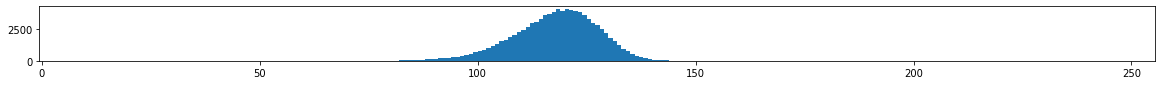

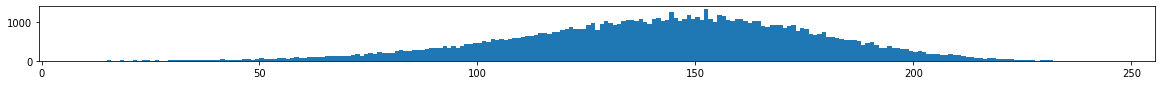

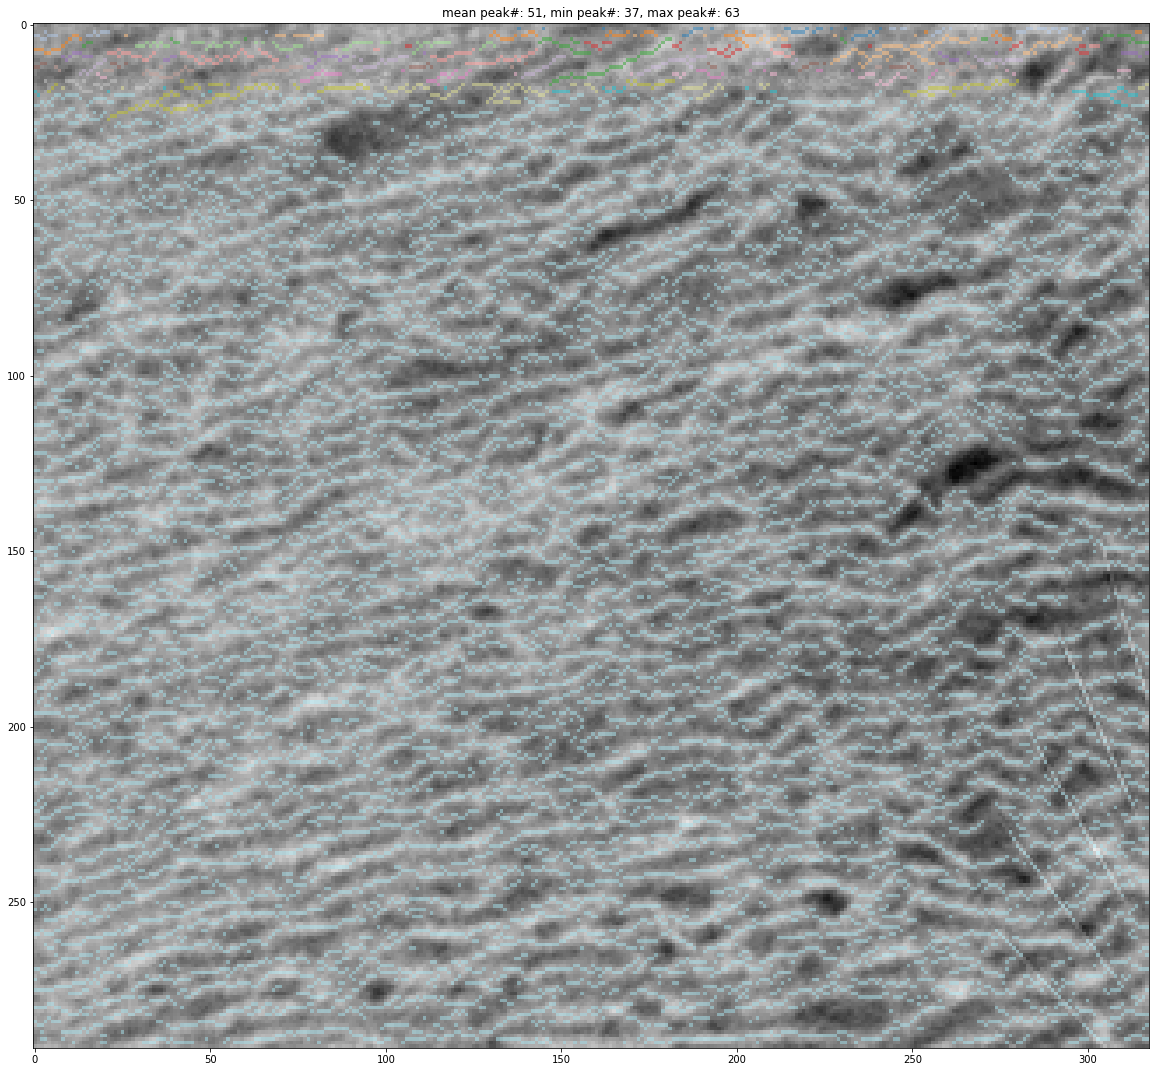

In [71]:
print(ndimg.shape)
# ndimg_eq = skimage.exposure.equalize_adapthist(ndimg)

for img,msk in zip(ndimg[50:51],ndmask[50:51]):
    # img = cv2.equalizeHist(img)
    # img = (unsharp_mask(unsharp_mask(img))*255).astype(np.uint8)
    # img = (unsharp_mask(rescale_intensity(img))*255).astype(np.uint8)
    fig = plt.figure(figsize=(20,1))
    counts, bins = np.histogram(img.reshape(-1), range(257))
    # plot histogram centered on values 0..255
    plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
    plt.xlim([-0.5, 255.5])
    print(len(np.unique(img)))
    fig = plt.figure(figsize=(20,1))
    counts, bins = np.histogram((skimage.exposure.equalize_adapthist(img)*255).reshape(-1), range(257))
    # plot histogram centered on values 0..255
    plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
    plt.xlim([-0.5, 255.5])
    
    
    for i in range(img.shape[1])[10::20]:
        x = img[:,i]
        peaks, _ = scipy.signal.find_peaks(x, height=0)
#         fig = plt.figure(figsize=(20,1))
#         plt.title(f"{i} - peaks  {len(peaks)}")
#         plt.plot(x)
#         plt.plot(peaks, x[peaks], 'x')
#         plt.show()
    
    thresh_mask = np.zeros_like(img)
    print(np.max(img))
    thresh_mask[img>150] = 1
#     axs.imshow(img, cmap="gray")
    grad = cv2.Canny((skimage.exposure.equalize_adapthist(img)*255).astype(np.uint8), 170, 200)
    print(grad.shape)

    peak_number = []
    valley_number = []
    peaks = np.zeros_like(img)
    valleys = np.zeros_like(img)
    peaks_idx = []
    for i in range(img.shape[1])[::1]:
        x = img[:,i]
        line_peaks, _ = scipy.signal.find_peaks(x, height=110)
        widths = scipy.signal.peak_widths(x, line_peaks, rel_height=0.5)
        if False:
            fig = plt.figure(figsize=(20,1))
            plt.plot(x)
            plt.plot(line_peaks, x[line_peaks], 'x')
            plt.ylabel("intensity")
            plt.xlabel("x")
            plt.show()
            plt.close()
        peak_number.append(len(line_peaks))
        # axs.axvline(i, alpha=0.5)
        for pi, peak in enumerate(line_peaks):
            width = widths[0][pi]
            left = widths[2][pi]
            right = widths[3][pi]
#             for fiber in range(int(np.floor(left)), int(np.ceil(right))+1):
#                 peaks[fiber,i] = 2
            peaks[peak, i] = 1
            peaks_idx.append((peak, i))
        line_valleys, _ = scipy.signal.find_peaks(255-x)
        valley_number.append(len(line_valleys))
        for valley in line_valleys:
            valleys[valley, i] = 1
        # axs.scatter(len(line_peaks)*[i], line_peaks, alpha=0.5, c="red", s=3)
    
    fig, axs  = plt.subplots(1,1, figsize=(20,20), squeeze=False)
    # axs[1].imshow(unsharp_mask(img), cmap="gray") # denoise_nl_means(unsharp_mask(img), patch_size=5, patch_distance=100), cmap="gray")
    axs[0,0].imshow(img, cmap="gray")
#     axs.imshow(grad, cmap=bb.plot.cm.default, alpha=0.5)
    labeled_peaks = label(peaks)
    axs[0,0].imshow(labeled_peaks, cmap=bb.plot.cm.tab20, alpha=0.5)
    # axs.imshow(valleys, cmap=bb.plot.cm.default, alpha=0.5)
#     kdtree: KDTree = KDTree(peaks_idx)
#     neighbor_idx = kdtree.query(peaks_idx, 1)
    # pairwise = squareform(pdist(peaks_idx))
    
    # axs[0].imshow(msk, alpha=0.5, cmap=bb.plot.cm.hsv, interpolation='none')
    # axs[1].imshow(skimage.exposure.equalize_adapthist(img ,kernel_size=(20,20))*255, cmap="gray", vmin=0, vmax=255)
    # axs[1].imshow(thresh_mask, alpha=0.5, cmap=bb.plot.cm.hsv, interpolation='none')
    axs[0,0].set_title(f"mean peak#: {np.mean(peak_number):.0f}, min peak#: {np.min(peak_number)}, max peak#: {np.max(peak_number)}")
    # axs.axvline(np.argmin(peak_number), alpha=0.5)
    plt.show()
    plt.close()